#### Пример работы с кодом

In [7]:
# чтобы изменения в других файлах автоматически подгружались в импорты
%load_ext IPython.extensions.autoreload
%autoreload 2

The IPython.extensions.autoreload extension is already loaded. To reload it, use:
  %reload_ext IPython.extensions.autoreload


In [8]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import datetime as dt

from data import FinData
from preprocessing import train_valid_split, train_valid_test_split
from model import CatboostFinModel

In [23]:
data = FinData("../datasets/T_yandex_10min.csv", column_names={'Yandex open' : 'open', 
                                          'Yandex close' : 'close', 
                                          'Yandex high' : 'high', 
                                          'Yandex low' : 'low', 
                                          'Yandex volume' : 'volume'})

data.insert_all()

In [24]:
data.get_columns()

Index(['utc', 'open', 'close', 'high', 'low', 'volume', 'direction_binary',
       'close_norms_3', 'close_high_norms_3', 'high_norms_3', 'low_norms_3',
       'close_norms_6', 'close_high_norms_6', 'high_norms_6', 'low_norms_6',
       'close_norms_18', 'close_high_norms_18', 'high_norms_18',
       'low_norms_18', 'hours', 'day', 'minute', 'is_holiday', 'pred_holiday',
       'week_pred_holiday', 'day_time', 'season', 'ma_3', 'close_normed_ma_3',
       'ma_6', 'close_normed_ma_6', 'ma_18', 'close_normed_ma_18', 'ema_3',
       'close_normed_ema_3', 'ema_6', 'close_normed_ema_6', 'ema_18',
       'close_normed_ema_18', 'rsi_3', 'close_normed_rsi_3', 'rsi_6',
       'close_normed_rsi_6', 'rsi_18', 'close_normed_rsi_18', 'ma_16',
       'close_normed_ma_16', 'SD', 'upper_bollinger', 'low_bollinger',
       'close_normed_upper_bollinger', 'close_normed_low_bollinger',
       'hl_diff_3', 'close_normed_hl_diff_3', 'hl_diff_6',
       'close_normed_hl_diff_6', 'hl_diff_18', 'close_normed_

In [47]:
numeric = ['close_norms_3',
       'close_high_norms_3', 'high_norms_3', 'low_norms_3', 'close_norms_6',
       'close_high_norms_6', 'high_norms_6', 'low_norms_6',
       'close_high_norms_18', 'high_norms_18', 'low_norms_18', 'day_time',
        'close_normed_ma_3', 'close_normed_ma_6', 'close_normed_ma_18', 'close_normed_ema_3',
       'close_normed_ema_6', 'close_normed_ema_18',
       'close_normed_rsi_3', 'rsi_6', 'close_normed_rsi_6', 'rsi_18',
       'close_normed_rsi_18', 'close_normed_ma_16', 'SD',
        'close_normed_upper_bollinger',
       'close_normed_low_bollinger', 'hl_diff_3',
       'hl_diff_6', 'hl_diff_18', 'stochastic_oscillator',
        'stochastic_oscillator_ma_3',
       'close_normed_stochastic_oscillator_ma_3', 'stochastic_oscillator_ma_6',
       'close_normed_stochastic_oscillator_ma_6',
       'stochastic_oscillator_ma_18',
       'close_normed_stochastic_oscillator_ma_18']

cat = []

args = {"iterations" : 10000, 
        "depth" : 5, 
        "learning_rate" : 0.01, # тут слегка неадекватные параметры, которые можно менять 
        "use_best_model" : True, 
        "l2_leaf_reg" : 200,
        "verbose" : 100, # отчет каждые 100 итераций 
        "loss_function" : 'CrossEntropy', 
        "eval_metric" : 'Accuracy', 
        "cat_features" : cat, 
        "random_state" : 42,
        "early_stopping_rounds" : 5000}

data.restrict_time_down(dt.datetime(2024, 11, 1))

In [21]:
data.check_stationarity(columns=numeric)

c:\Users\Валерия\OneDrive\Документы\GitHub\prices-predictions\myenv\Lib\site-packages\numpy\lib\function_base.py:1452: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])
c:\Users\Валерия\OneDrive\Документы\GitHub\prices-predictions\myenv\Lib\site-packages\numpy\lib\function_base.py:1452: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


Ошибка при обработке столбца 'close_normed_rsi_3': exog contains inf or nans
Ошибка при обработке столбца 'close_normed_rsi_6': exog contains inf or nans


c:\Users\Валерия\OneDrive\Документы\GitHub\prices-predictions\myenv\Lib\site-packages\numpy\lib\function_base.py:1452: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


Ошибка при обработке столбца 'close_normed_rsi_18': exog contains inf or nans
Ошибка при обработке столбца 'stochastic_oscillator': exog contains inf or nans


In [48]:
X_train, X_val, y_train, y_val = train_valid_split(data=data.df, 
                                                   year=2024, month=12, day=5, 
                                                   numeric=numeric, cat=cat, target="direction_binary")

In [49]:
model = CatboostFinModel(args)

model.set_datasets(X_train, X_val, y_train, y_val)
model.set_features(numeric, cat)

model.fit()

0:	learn: 0.5872969	test: 0.5707071	best: 0.5707071 (0)	total: 6.82ms	remaining: 1m 8s
100:	learn: 0.6230428	test: 0.5959596	best: 0.6212121 (18)	total: 688ms	remaining: 1m 7s
200:	learn: 0.6304284	test: 0.5909091	best: 0.6212121 (18)	total: 1.77s	remaining: 1m 26s
300:	learn: 0.6449040	test: 0.5959596	best: 0.6212121 (18)	total: 2.39s	remaining: 1m 17s
400:	learn: 0.6519941	test: 0.5858586	best: 0.6212121 (18)	total: 2.91s	remaining: 1m 9s
500:	learn: 0.6549483	test: 0.5909091	best: 0.6212121 (18)	total: 3.44s	remaining: 1m 5s
600:	learn: 0.6614476	test: 0.5909091	best: 0.6212121 (18)	total: 4.06s	remaining: 1m 3s
700:	learn: 0.6649926	test: 0.5909091	best: 0.6212121 (18)	total: 4.6s	remaining: 1m 1s
800:	learn: 0.6694239	test: 0.5909091	best: 0.6212121 (18)	total: 5.14s	remaining: 59s
900:	learn: 0.6741507	test: 0.5909091	best: 0.6212121 (18)	total: 5.65s	remaining: 57.1s
1000:	learn: 0.6782866	test: 0.5909091	best: 0.6212121 (18)	total: 6.25s	remaining: 56.2s
1100:	learn: 0.6821270	

In [29]:
model.print_constant_accuracy(y_val)

Точность константного предсказания 0.5404040404040404


In [46]:
model.print_feature_importances()

0.7686833575320672 rsi_3
0.852900709265363 close_norms_18
1.0687230254372724 close_high_norms_18
1.0870001381985386 rsi_18
1.1115533468750602 close_high_norms_6
1.1777794553943033 stochastic_oscillator_ma_3
1.2556138059228144 close_norms_3
1.281080084236509 close_norms_6
1.3080915348405504 rsi_6
1.4044171440932742 close_normed_ema_18
1.416229958701726 stochastic_oscillator_ma_6
1.4404575702290228 stochastic_oscillator_ma_18
1.4817670682248998 high_norms_18
1.604348820929571 day_time
1.6457743674007943 close_high_norms_3
1.741320945326081 close_normed_stochastic_oscillator_ma_6
1.751912365131907 close_normed_ma_18
2.18326733034475 close_normed_ma_16
2.2894283537587903 low_norms_18
2.335290088415954 stochastic_oscillator
2.366560305643192 close_normed_stochastic_oscillator_ma_3
2.454220067618493 close_normed_ma_6
2.5006984839149946 close_normed_rsi_18
2.7285678855948676 close_normed_ema_6
2.901153281738134 close_normed_stochastic_oscillator_ma_18
2.964422124702613 hl_diff_3
2.99033938542

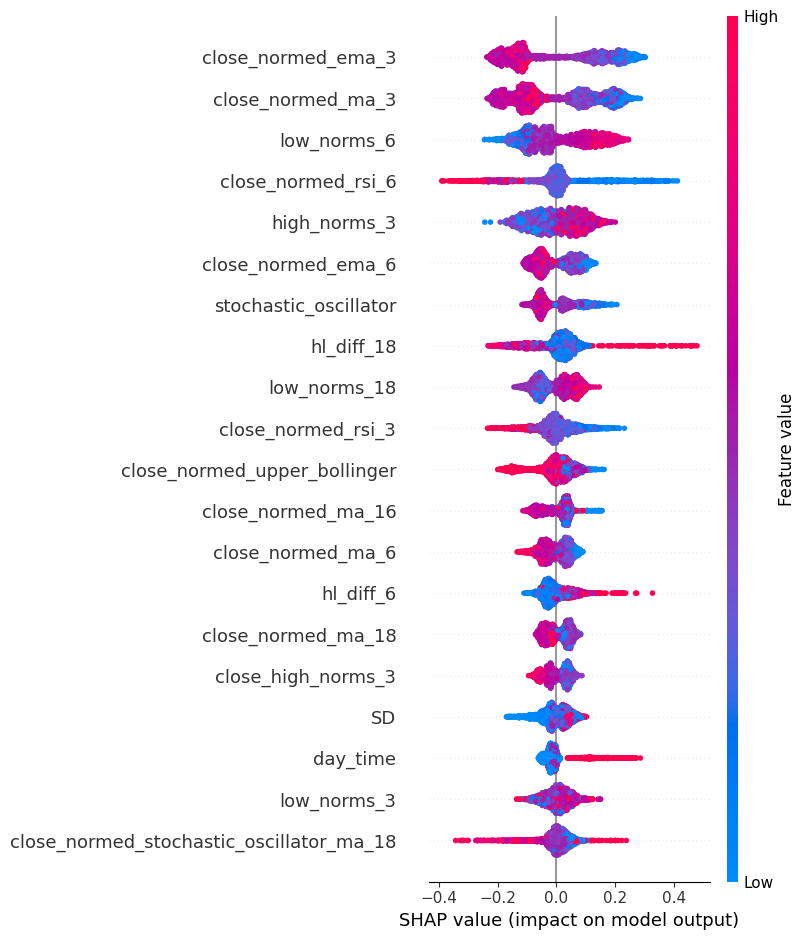

In [43]:
model.visualise_shap_values()